# Modelo para producción

## Importación de librerías

Importamos la librerías necesarias.

In [1]:
## Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
## Para el cálculo de distancias entre apartamentos y medios de transporte
from geopy.distance import distance
from decimal import *
## Librerías para el entrenamiento del modelo
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from xgboost import XGBRegressor
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, HuberRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
## Para exportar el modelo entrenado
from skops.io import dump

## Import Data
Cargamos el Data Set con el que entrenaremos el modelo.

In [2]:
output_file_path = '../data/listings.csv'
df = pd.read_csv(output_file_path, low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25288 entries, 0 to 25287
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            25288 non-null  int64  
 1   listing_url                                   25288 non-null  object 
 2   scrape_id                                     25288 non-null  int64  
 3   last_scraped                                  25288 non-null  object 
 4   source                                        25288 non-null  object 
 5   name                                          25288 non-null  object 
 6   description                                   24375 non-null  object 
 7   neighborhood_overview                         11218 non-null  object 
 8   picture_url                                   25287 non-null  object 
 9   host_id                                       25288 non-null 

## Preparación del _Data Set_ de entrenamiento

### Limpieza inicial de los datos

Eliminamos todas aquellos datos que no encontraremos en el _Data Set_ de Idealista.

También eliminaremos aquellos datos que no estén relacionados con el precio de los apartamentos.

In [4]:
df = df.drop(columns=['id','listing_url', 
                      'neighbourhood_cleansed','minimum_nights','maximum_nights',
                      'estimated_occupancy_l365d','estimated_revenue_l365d','scrape_id',
                      'last_scraped','source','neighborhood_overview',
                      'host_id','host_url','host_name',
                      'host_since','host_location','host_response_time',
                      'host_response_rate','host_acceptance_rate','host_is_superhost',
                      'host_thumbnail_url','host_picture_url','host_listings_count',
                      'host_total_listings_count','host_verifications','host_has_profile_pic',
                      'host_identity_verified','neighbourhood','bathrooms_text',
                      'beds','minimum_minimum_nights','maximum_minimum_nights',
                      'minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                      'maximum_nights_avg_ntm','has_availability','calendar_last_scraped',
                      'number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d',
                      'availability_eoy','number_of_reviews_ly','first_review',
                      'last_review','review_scores_rating','review_scores_accuracy',
                      'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                      'review_scores_location','review_scores_value','license',
                      'instant_bookable','calculated_host_listings_count','calculated_host_listings_count_entire_homes',
                      'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month',
                      'host_about','host_neighbourhood','calendar_updated',
                      'availability_30','availability_60','availability_90',
                      'availability_365','picture_url','accommodates'])

Eliminamos las habitaciones, casas compartidas, hoteles, etc. ya que solo queremos VIVIENDAS COMPLETAS.

In [5]:
df = df[df['room_type']== 'Entire home/apt'].copy()

También utilizamos los datos de "_room_type_" para borrar aquellos datos que no sean viviendas que hagan referencia a cámpers, apartahoreles o bungalows.

In [6]:
property_types_to_remove = ['Camper/RV', 'Room in aparthotel', 'Entire cabin','Hut','Yurt','Entire Bungalow']
df = df[~df['property_type'].isin(property_types_to_remove)].copy()

También eliminaremos los anuncios que se encuentren duplicados. Para ello, compararemos los datos de 2 parámetros, "_name_" y "_description_", para encontrar aquellos anuncios donde este campo se encuentre duplicado, en cuyo caso, borraremos dichos anuncios menos 1.

In [7]:
df["name_description"] = df["name"].fillna(" ").str.lower() + " and " + df["description"].fillna(" ").str.lower()
df["name_description"].groupby(df["name_description"]).count()[df["name_description"].groupby(df["name_description"]).count() > 1].sort_values(ascending=False)

name_description
flamenco style apartment | palacio real, la latina and wonderful apartment located just above one of the oldest flamenco tablao in madrid, the corral de la morería, recently renovated opting for quality and comfort, offering an incredible rest. located in one of the most central areas of madrid that offers a multitude of restaurants, leisure and culture a few steps from the nerve center of the city. it has a bedroom with a queen size bed, a sofa bed, complete kitchen and a bathroom. whether for leisure or work, enjoy your apartment!            14
home art madrid estudio estándar and this studio apartment has impeccable interior design. its modern style makes it one of the most practical. everything is paid to attention to every last detail. due to its unbeatable location and interior care, it is perfect to enjoy one of the most sought-after areas in madrid.                                                                                                                  

In [8]:
df.drop_duplicates(subset=["name_description"], keep="first", inplace=True)

Además, dado que nuestro valor _target_ será el precio por noche, eliminaremos todos aquellos apartamentos que no tengan precio.

In [9]:
df.dropna(subset=['price'], how='any', inplace=True)

### Preprocesamiento de datos iniciales

Por un lado, completamos los valores desconocidos con 0 en los campos referentes a los baños y las habitaciones, y los convertimos a tipo de dato "_int_". Además, entendemos que en todos aquellos apartamentos que tengan 0 habitaciones y 0 baños, realmente cuenta con un mínimo de 1 en cada caso, por lo que sustituimos dichos 0 por 1.

Por otro lado, convertimos los datos de precios por noche en tipo "_float_".

In [10]:
df['bathrooms'] = df['bathrooms'].replace([np.inf,-np.inf],np.nan).fillna(0).astype(int)
df['bedrooms'] = df['bedrooms'].replace([np.inf,-np.inf],np.nan).fillna(0).astype(int)

df['bathrooms'] = df['bathrooms'].replace(0,1)
df['bedrooms'] = df['bedrooms'].replace(0,1)

df['price'] = df['price'].replace({'\\$': '', ',': ''}, regex=True).astype(float)

#### Comodidades o servicios (_amenities_)

De los datos de "_amenities_", extraemos aquellos datos con los que contamos dentro del DS de Idealista:
- Calefacción
- Piscina
- Garaje
- Aire acondicionado
- Ascensor
- Movilidad reducida

In [11]:
df['calefaccion'] = df['amenities'].apply(lambda x: 1 if 'heating' in x.lower() else 0)
df['piscina'] = df['amenities'].apply(lambda x: 1 if ('pool' in str.lower(x)) and ('whirlpool' not in str.lower(x)) and ('whirpool' not in str.lower(x)) else 0)
df['garaje'] = df['amenities'].apply(lambda x: 1 if 'free parking' in x.lower() else 0)
df['aire_acondicionado'] = df['amenities'].apply(lambda x: 1 if 'air conditi' in str.lower(x) else 0)
df['ascensor'] = df['amenities'].apply(lambda x: 1 if 'elevator' in str.lower(x) else 0)
df['movilidad_reducida'] = df['amenities'].apply(lambda x: 1 if 'single level home' in str.lower(x) else 0)

No tiene sentido que el apartamento cuente con instalaciones para mobilidad reducida pero que no cuente con ascensor. Esto solo tendría sentido si el apartamento se encontrara en una planta baja.

Es por ello que cambiaremos a 0 el valor de _movilidad_reducida_ en todos aquellos apartamentos que en dicho valor tengan un 1 pero que no cuenten con ascensor.

In [12]:
df.loc[(df['movilidad_reducida'] == 1) & (df['ascensor'] == 0), "movilidad_reducida"] = 0

#### Descripción del apartamento (_name_description_)

De la columna creada anteriormente "_name_description_", se pueden obtener más datos en cuanto a terrazas y balcones.

In [13]:
df["terraza"] = df["name_description"].apply(lambda x: 1 if "terrace" in x else 0)
df["balcon"] = df["name_description"].apply(lambda x: 1 if "balcon" in x else 0)

### Creación de nuevas variables

Para enriquecer nuestro modelo, una de las mejores formas de hacerlo es obtener nuevas variables que puedan dar más información.

#### Distancia a puntos estratégicos de Madrid

Entendemos que unos de los mayores atractivos de los apartamentos turísitcos es la ubicación en la que se encuentran. Es por ello que hemos calculado la distancia de cada uno de los apartamentos a 4 puntos diferentes de Madrid que entendemos que son de mayor interés a la hora de buscar un apartamento turísitico:
- Centro de Madrid (Puerta del Sol)
- Parque de El Retiro
- Estación de Atocha
- Estación de Chamartín

In [14]:
# Create distance to city center
center_lat, center_lon = 40.4168, -3.7038
df['distance_to_center'] = np.sqrt((df['latitude'] - center_lat)**2 + (df['longitude'] - center_lon)**2)

# Create distance to El Retiro
retiro_lat, retiro_lon = 40.415262, -3.6883366
df['distance_to_retiro'] = np.sqrt((df['latitude'] - retiro_lat)**2 + (df['longitude'] - retiro_lon)**2)

# Create distance to Atocha
atocha_lat, atocha_lon = 40.405383, -3.6914676
df['distance_to_atocha'] = np.sqrt((df['latitude'] - atocha_lat)**2 + (df['longitude'] - atocha_lon)**2)

# Create distance to Chamartín
chamartin_lat, chamartin_lon = 40.472103, -3.6852973
df['distance_to_chamartin'] = np.sqrt((df['latitude'] - chamartin_lat)**2 + (df['longitude'] - chamartin_lon)**2)

#### Data Import of Rentas Ayto Madrid

Se han obtenido datos de las rentas que hay en cada distrito:
- Renta neta media por persona
- Renta neta media por hogar
- Media de la renta neta por unidad de consumo
- Mediana de la renta netat por unidad de consumo
- Renta bruta media por persona
- Renta media bruta por hogar

In [15]:
df_rentas = pd.read_csv('../data/Datos_Rentas_Madrid_2022.csv',delimiter=";")
df_rentas.head()

Distrito  Renta neta media por persona  Renta neta media por hogar  \
0      01. Centro                        20.587                      41.059   
1  02. Arganzuela                        21.383                      49.236   
2      03. Retiro                        25.407                      60.762   
3   04. Salamanca                        28.140                      64.925   
4   05. Chamartín                        30.506                      74.842   

   Media de la renta neta por unidad de consumo  \
0                                        28.500   
1                                        31.038   
2                                        37.916   
3                                        42.592   
4                                        47.564   

   Mediana de la renta neta por unidad de consumo  \
0                                           22.05   
1                                           28.35   
2                                           31.85   
3                                           31.15   
4                                           34.65   

   Renta bruta media por persona  Renta media bruta por hogar  
0                         27.030                       53.908  
1                         27.431                       63.160  
2                         33.396                       79.868  
3                         38.751                       89.407  
4                         42.678                      104.706

Las rentas aparecen divididas entre 1000 en el DS obtenido.

In [16]:
for col in df_rentas.select_dtypes(include='float'):
    df_rentas[col] = df_rentas[col].apply(lambda x: x * 1000)

df_rentas.head()

Distrito  Renta neta media por persona  Renta neta media por hogar  \
0      01. Centro                       20587.0                     41059.0   
1  02. Arganzuela                       21383.0                     49236.0   
2      03. Retiro                       25407.0                     60762.0   
3   04. Salamanca                       28140.0                     64925.0   
4   05. Chamartín                       30506.0                     74842.0   

   Media de la renta neta por unidad de consumo  \
0                                       28500.0   
1                                       31038.0   
2                                       37916.0   
3                                       42592.0   
4                                       47564.0   

   Mediana de la renta neta por unidad de consumo  \
0                                         22050.0   
1                                         28350.0   
2                                         31850.0   
3                                         31150.0   
4                                         34650.0   

   Renta bruta media por persona  Renta media bruta por hogar  
0                        27030.0                      53908.0  
1                        27431.0                      63160.0  
2                        33396.0                      79868.0  
3                        38751.0                      89407.0  
4                        42678.0                     104706.0

A continuación, unificamos los nombres de los distritos de ambos DS, de forma que en el de las rentas aparezcan los mimos nombres que en el DS de AirBnB.

In [17]:
df_rentas['Distrito'] = df_rentas['Distrito'].str[4:]
df_rentas['Distrito'] = df_rentas['Distrito'].apply(lambda x: x.replace('-', ' - ') if '-' in x else x)
df_rentas.head(21)

Distrito  Renta neta media por persona  \
0                  Centro                       20587.0   
1              Arganzuela                       21383.0   
2                  Retiro                       25407.0   
3               Salamanca                       28140.0   
4               Chamartín                       30506.0   
5                  Tetuán                       18062.0   
6                Chamberí                       27076.0   
7   Fuencarral - El Pardo                       21947.0   
8       Moncloa - Aravaca                       26694.0   
9                  Latina                       14375.0   
10            Carabanchel                       12764.0   
11                  Usera                       11430.0   
12     Puente de Vallecas                       11452.0   
13              Moratalaz                       16437.0   
14          Ciudad Lineal                       17808.0   
15              Hortaleza                       21766.0   
16             Villaverde                       11563.0   
17      Villa de Vallecas                       14274.0   
18              Vicálvaro                       14832.0   
19  San Blas - Canillejas                       15902.0   
20                Barajas                       20788.0   

    Renta neta media por hogar  Media de la renta neta por unidad de consumo  \
0                      41059.0                                       28500.0   
1                      49236.0                                       31038.0   
2                      60762.0                                       37916.0   
3                      64925.0                                       42592.0   
4                      74842.0                                       47564.0   
5                      42465.0                                       25955.0   
6                      60032.0                                       40145.0   
7                      58214.0                                       34241.0   
8                      68238.0                                       41666.0   
9                      35669.0                                       20833.0   
10                     33786.0                                       18831.0   
11                     31996.0                                       17143.0   
12                     30339.0                                       16852.0   
13                     40325.0                                       23900.0   
14                     43738.0                                       26175.0   
15                     57506.0                                       34164.0   
16                     32527.0                                       17366.0   
17                     36998.0                                       21433.0   
18                     39505.0                                       22364.0   
19                     41474.0                                       23785.0   
20                     54343.0                                       31942.0   

    Mediana de la renta neta por unidad de consumo  \
0                                          22050.0   
1                                          28350.0   
2                                          31850.0   
3                                          31150.0   
4                                          34650.0   
5                                          20650.0   
6                                          31150.0   
7                                          28350.0   
8                                          30450.0   
9                                          18550.0   
10                                         16450.0   
11                                         15050.0   
12                                         15050.0   
13                                         21350.0   
14                                         21350.0   
15                                         26950.0   
16                                     

Para enriquecer los datos de AirBnB con las rentas de Madrid, extraeremos los datos de "_Renta neta media por hogar_" y crearemos una nueva columna "_renta_bin_".

En dicha columna se han segmentado y ordenado los datos de "_Renta neta media por hogar_" de cada uno de los distrito en 5 etiquetas diferentes de mayor a menor renta.

In [18]:
df_rentas['renta_bin'] = pd.cut(
    df_rentas['Renta neta media por hogar'].sort_values(),
    bins=5,
    labels=['muy_bajo','bajo','medio','alto','muy_alto'],
    include_lowest=True
)
df_rentas[['Distrito', 'Renta neta media por hogar', 'renta_bin']]

def get_renta_bin(distrito:str):
    # Busca el distrito en df_rentas y devuelve el valor de 'renta_bin'
    row = df_rentas[df_rentas['Distrito'] == distrito]
    if not row.empty:
        return row['renta_bin'].values[0]
    else:
        return None

In [19]:
df["renta_bin"] = df['neighbourhood_group_cleansed'].apply(lambda x: get_renta_bin(x))

#### Cálculo de distancia Ubicación Alojamiento - Medios de Transportes de Madrid

Hemos obtenido un DS donde aparecen las paradas de diferentes medios de transporte a los que se puede acceder en la ciudad de Madrid.

De dicho DS lo que queremos obtener es la distancia de los diferentes apartamentos las paradas más cercanas de cada uno de estos medios de transporte:
- Metro
- Cercanías
- Interurbanos
- Empresa Municipal de Transportes de Madrid(EMT)
- Metro Ligero Oeste (MLO)

In [20]:
stops = pd.read_csv('../data/TRANSPORTS.csv')

In [21]:
TIPOS_TRANSPORTE = [4,5,6,8,10] #El 9 está integrado en el 8

In [22]:
def calcular_distancias_vivienda(row_viv):
    resultados = {}
    
    for modo in TIPOS_TRANSPORTE:
        paradas_tipo = stops[stops['mode'] == modo]

        if paradas_tipo.empty:
            resultados[f'distancia_mode_{modo}'] = None
            continue

        # filtrar primero por lat/lon cercanas para acelerar

        delta = 0.01
        paradas_candidatas = paradas_tipo[
            (abs(paradas_tipo['lat'] - row_viv['latitude']) < delta) &
            (abs(paradas_tipo['lon'] - row_viv['longitude']) < delta)
        ]




        """ Para mejorar el rendimiento voy iterando incrementando el delta a comprobar, tengo que 
        asegurarme de que haya al menos una parada en el dataset porque sino morimos en el while"""
        while paradas_candidatas.empty:  
            delta += 0.01
            print(f"Buscando paradas cercanas al modo {modo} con delta {delta}")
            paradas_candidatas = paradas_tipo[
                (abs(paradas_tipo['lat'] - row_viv['latitude']) < delta) &
                (abs(paradas_tipo['lon'] - row_viv['longitude']) < delta)
            ]
      

        # if paradas_candidatas.empty:
        #     paradas_candidatas = paradas_tipo  # fallback a todas

        distancias = paradas_candidatas.apply(
            lambda stop: distance(
                (row_viv['latitude'], row_viv['longitude']),
                (stop['lat'], stop['lon'])
            ).meters,
            axis=1
        )

        resultados[f'distancia_mode_{modo}'] = distancias.min()

    return pd.Series(resultados)

In [23]:
new_bnb_dataset = df.apply(calcular_distancias_vivienda, axis=1)
df = pd.concat([df, new_bnb_dataset], axis=1)
df

Buscando paradas cercanas al modo 10 con delta 0.02
Buscando paradas cercanas al modo 10 con delta 0.03
Buscando paradas cercanas al modo 10 con delta 0.04
Buscando paradas cercanas al modo 10 con delta 0.05
Buscando paradas cercanas al modo 10 con delta 0.060000000000000005
Buscando paradas cercanas al modo 8 con delta 0.02
Buscando paradas cercanas al modo 10 con delta 0.02
Buscando paradas cercanas al modo 10 con delta 0.03
Buscando paradas cercanas al modo 10 con delta 0.04
Buscando paradas cercanas al modo 10 con delta 0.05
Buscando paradas cercanas al modo 10 con delta 0.060000000000000005
Buscando paradas cercanas al modo 8 con delta 0.02
Buscando paradas cercanas al modo 10 con delta 0.02
Buscando paradas cercanas al modo 10 con delta 0.03
Buscando paradas cercanas al modo 10 con delta 0.04
Buscando paradas cercanas al modo 10 con delta 0.05
Buscando paradas cercanas al modo 10 con delta 0.060000000000000005
Buscando paradas cercanas al modo 10 con delta 0.07
Buscando paradas c

name  \
5                          Tu hogar en centro de Madrid.   
6        Heart of Malasaña Cozy, Quiet & Sunny Apartment   
7       Sunny attic duplex flat with terrace next to Sol   
9                      Cool Apart. (10min Center + WIFI)   
10     Cozy attic with intimate rooftop terrace+ elev...   
...                                                  ...   
25281                         Coqueto estudio en tetuan!   
25282                          Bonito estudio en Tetuán!   
25283        Acogedor y nuevo ático con gran terraza (B)   
25284                    Elegante apartamento en Madrid!   
25285                          Tropical apartment Madrid   

                                             description  \
5      Very nice, cozy and bright, right in the cente...   
6      Cozy Apartment in great location in the center...   
7      Nestled in the serene heart of Madrid, this re...   
9      Cool and confortable 1 bedroom apartment for 2...   
10     Nestled in Madrid's tranquil heart, this apart...   
...                                                  ...   
25281  Disconnect from the routine in this charming a...   
25282  Get away from routine at this unique and relax...   
25283  Cozy penthouse floor with large terrace, locat...   
25284  Have fun with the whole family at this stylish...   
25285  Get away from routine at this unique and relax...   

      neighbourhood_group_cleansed   latitude  longitude       property_type  \
5                           Centro  40.423810  -3.710380  Entire rental unit   
6                           Centro  40.422520  -3.702500  Entire rental unit   
7                           Centro  40.411500  -3.704490  Entire rental unit   
9                           Centro  40.408660  -3.703740  Entire rental unit   
10                          Centro  40.409390  -3.698120  Entire rental unit   
...                            ...        ...        ...                 ...   
25281                       Tetuán  40.464951  -3.704578  Entire rental unit   
25282                       Tetuán  40.468355  -3.706939  Entire rental unit   
25283                    Hortaleza  40.464110  -3.647130  Entire rental unit   
25284                  Carabanchel  40.395983  -3.730953  Entire rental unit   
25285                  Carabanchel  40.395621  -3.731533  Entire rental unit   

             room_type  bathrooms  bedrooms  \
5      Entire home/apt          1         1   
6      Entire home/apt          1         1   
7      Entire home/apt          1         3   
9      Entire home/apt          1         1   
10     Entire home/apt          1         3   
...                ...        ...       ...   
25281  Entire home/apt          1         1   
25282  Entire home/apt          1         1   
25283  Entire home/apt          1         1   
25284  Entire home/apt          1         2   
25285  Entire home/apt          1         1   

                                               amenities  ...  \
5      ["Paid parking off premises", "Window AC unit"...  ...   
6      ["Portable fans", "Paid parking off premises",...  ...   
7      ["Wifi", "Dishes and silverware", "Oven", "Hot...  ...   
9      ["Portable fans", "Pocket wifi", "Single level...  ...   
10     ["Smoke alarm", "Pack \u2019n play/Travel crib...  ...   
...                                                  ...  ...   
25281  ["Air conditioning", "Pets allowed", "Wifi", "...  ...   
25282  ["Air conditioning", "Pets allowed", "Wifi", "...  ...   
25283  ["Cleaning available during stay", "Wifi", "Wi...  ...   
25284  ["Pets allowed", "Kitchen", "TV", "Air conditi...  ...   
25285  ["Pets allowed", "Kitchen", "TV", "Air conditi...  ...   

       distance_to_center distance_to_retiro  distance_to_atocha  \
5                0.009614           0.023643            0.026405   
6                0.005866           0.015915            0.020381   
7                0.005345           0.016586            0.014388   
9                0.008140      

In [24]:
df.rename(columns={
    'distancia_mode_4': 'DISTANCE_TO_METRO',
    'distancia_mode_5': 'DISTANCE_TO_CERCANIAS',
    'distancia_mode_6': 'DISTANCE_TO_EMT',
    'distancia_mode_8': 'DISTANCE_TO_INTERURBANOS',
    'distancia_mode_10': 'DISTANCE_TO_MLO'
}, inplace=True)

### Outliers

A continuación, nos deshacemos de los "_outliers_" que puedan afectar en el entrenamiento de nuestro modelo.

In [25]:
df_numerics_Q1 = df[['price']].apply(lambda x: np.quantile(x,q=.25)) # indicadores de Q1
df_numerics_Q3 = df[['price']].apply(lambda x: np.quantile(x,q=.75)) # indicadores de Q2
df_numerics_IQR = df_numerics_Q3 - df_numerics_Q1 # longitud del IQR
df_numerics_lower = df_numerics_Q1 - 1.5 * df_numerics_IQR # limite inferior
df_numerics_upper = df_numerics_Q3 + 1.5 * df_numerics_IQR # limite superior

In [26]:
df.shape

(13626, 30)

In [27]:
df_numerics_over_max = df[['price']].apply(lambda x: x> df_numerics_upper,axis=1)
df_numerics_below_min = df[['price']].apply(lambda x: x< df_numerics_lower,axis=1)

samples_with_outliers_price_pers = df_numerics_below_min.any(axis=1) | df_numerics_over_max.any(axis=1)

In [28]:
df = df[~samples_with_outliers_price_pers]

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12630 entries, 5 to 25285
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   name                          12630 non-null  object 
 1   description                   12317 non-null  object 
 2   neighbourhood_group_cleansed  12630 non-null  object 
 3   latitude                      12630 non-null  float64
 4   longitude                     12630 non-null  float64
 5   property_type                 12630 non-null  object 
 6   room_type                     12630 non-null  object 
 7   bathrooms                     12630 non-null  int64  
 8   bedrooms                      12630 non-null  int64  
 9   amenities                     12630 non-null  object 
 10  price                         12630 non-null  float64
 11  name_description              12630 non-null  object 
 12  calefaccion                   12630 non-null  int64  
 13  piscin

### Correlacion

In [30]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

[Text(0.5, 0, 'latitude'),
 Text(1.5, 0, 'longitude'),
 Text(2.5, 0, 'bathrooms'),
 Text(3.5, 0, 'bedrooms'),
 Text(4.5, 0, 'price'),
 Text(5.5, 0, 'calefaccion'),
 Text(6.5, 0, 'piscina'),
 Text(7.5, 0, 'garaje'),
 Text(8.5, 0, 'aire_acondicionado'),
 Text(9.5, 0, 'ascensor'),
 Text(10.5, 0, 'movilidad_reducida'),
 Text(11.5, 0, 'terraza'),
 Text(12.5, 0, 'balcon'),
 Text(13.5, 0, 'distance_to_center'),
 Text(14.5, 0, 'distance_to_retiro'),
 Text(15.5, 0, 'distance_to_atocha'),
 Text(16.5, 0, 'distance_to_chamartin'),
 Text(17.5, 0, 'DISTANCE_TO_METRO'),
 Text(18.5, 0, 'DISTANCE_TO_CERCANIAS'),
 Text(19.5, 0, 'DISTANCE_TO_EMT'),
 Text(20.5, 0, 'DISTANCE_TO_INTERURBANOS'),
 Text(21.5, 0, 'DISTANCE_TO_MLO')]

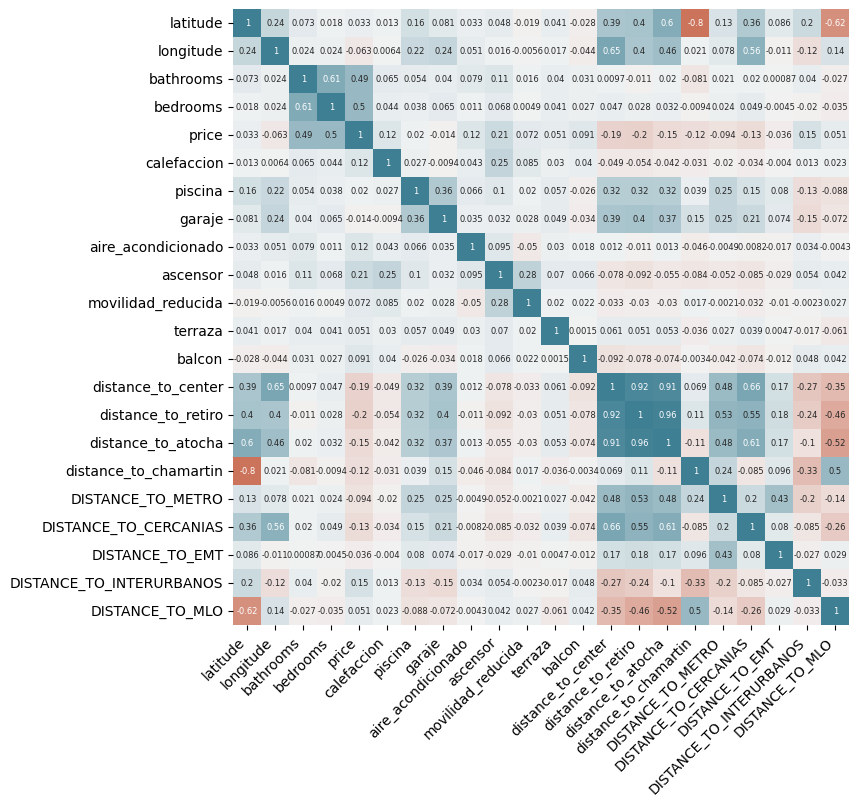

In [31]:
import seaborn as sns

corr_matrix = df.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)


### Histograma de los datos

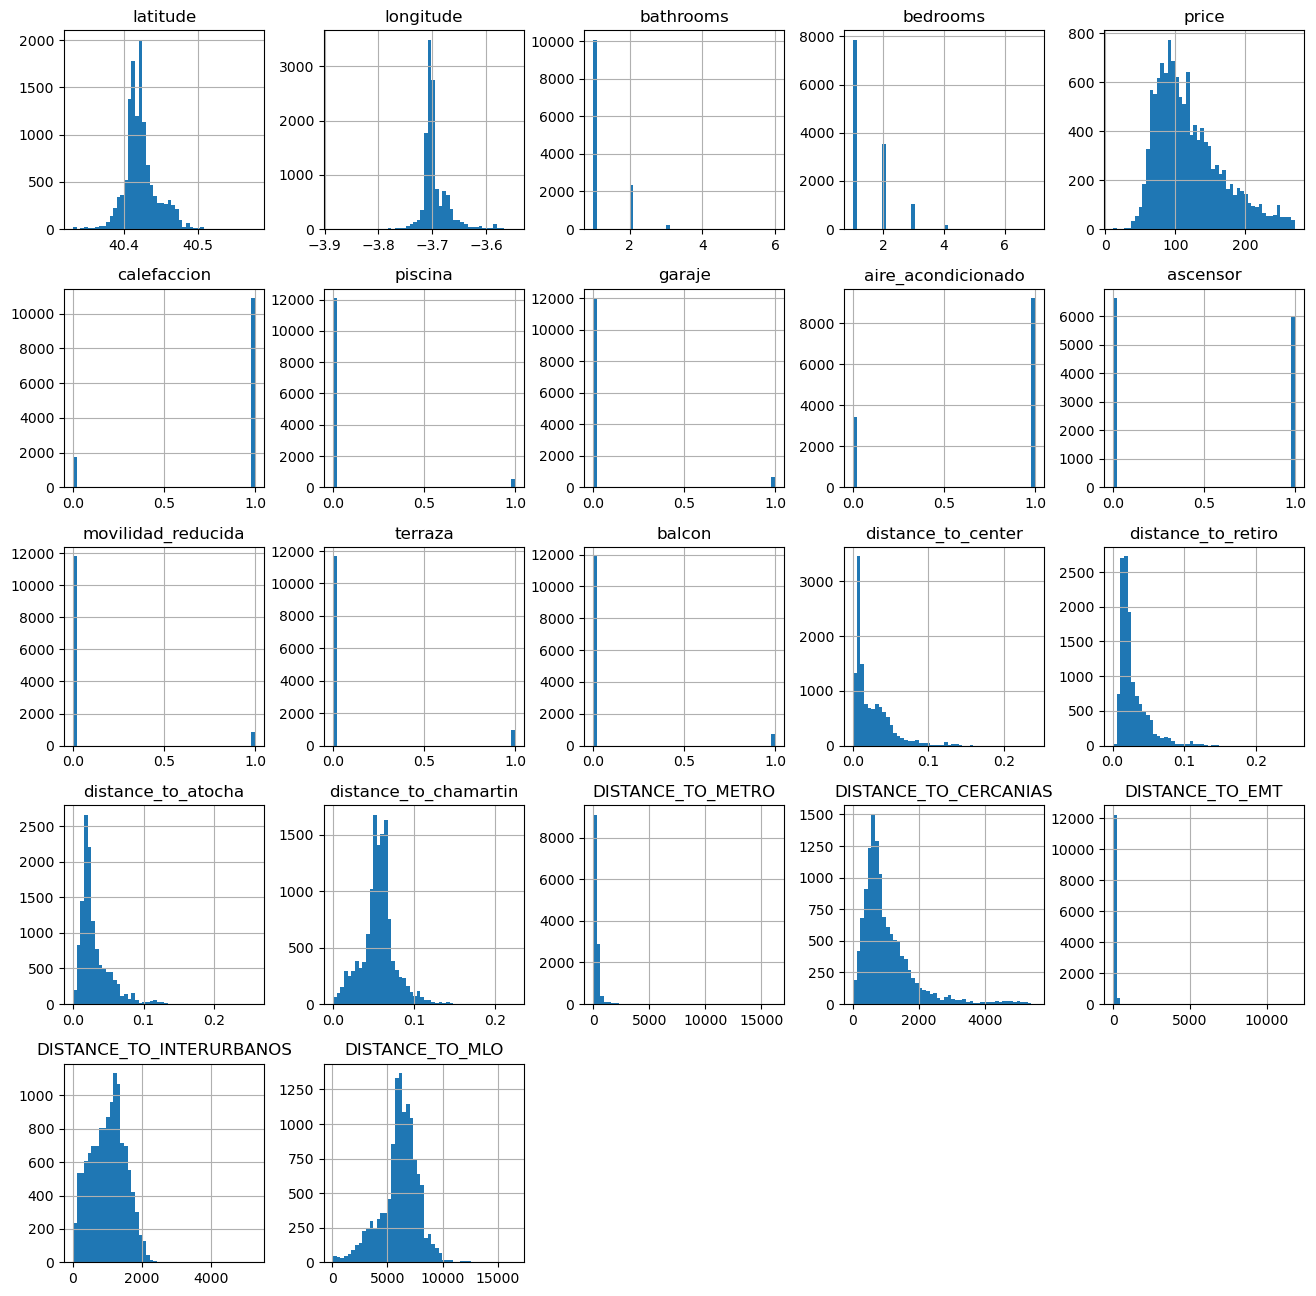

In [32]:
import matplotlib.pyplot as plt
df.hist(bins=50,figsize=(16, 16))
plt.show()

### _Data Set_ definitivo para entrenamiento del modelo

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12630 entries, 5 to 25285
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   name                          12630 non-null  object 
 1   description                   12317 non-null  object 
 2   neighbourhood_group_cleansed  12630 non-null  object 
 3   latitude                      12630 non-null  float64
 4   longitude                     12630 non-null  float64
 5   property_type                 12630 non-null  object 
 6   room_type                     12630 non-null  object 
 7   bathrooms                     12630 non-null  int64  
 8   bedrooms                      12630 non-null  int64  
 9   amenities                     12630 non-null  object 
 10  price                         12630 non-null  float64
 11  name_description              12630 non-null  object 
 12  calefaccion                   12630 non-null  int64  
 13  piscin

Eliminamos más columnas que hemos utilizado para obtener otros parámetros con los que no contábamos inicialmente pero que no son útiles para el entrenamiento del modelo.

In [34]:
columns_to_drop = ['name', 'description', 'name_description','amenities','room_type','property_type','latitude','longitude']
df.drop(columns=columns_to_drop, inplace=True)
df.columns

/var/folders/y1/nqw3rhqs1xv4s4gzlmjk02680000gn/T/ipykernel_15883/4211595096.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)


Index(['neighbourhood_group_cleansed', 'bathrooms', 'bedrooms', 'price',
       'calefaccion', 'piscina', 'garaje', 'aire_acondicionado', 'ascensor',
       'movilidad_reducida', 'terraza', 'balcon', 'distance_to_center',
       'distance_to_retiro', 'distance_to_atocha', 'distance_to_chamartin',
       'renta_bin', 'DISTANCE_TO_METRO', 'DISTANCE_TO_CERCANIAS',
       'DISTANCE_TO_EMT', 'DISTANCE_TO_INTERURBANOS', 'DISTANCE_TO_MLO'],
      dtype='object')

In [35]:
len(df)

12630

In [36]:
df.to_csv('../data/df_entrenamiento.csv', index=False)

## Modelo

A continuación, entrenamos el modelo.

In [37]:
dfm = pd.read_csv('../data/df_entrenamiento.csv')

In [38]:
dfm.shape

(12630, 22)

### Preparación de los sets

Dividimos el DS en _train_ (80%) y _test_ (20%).

In [39]:
target = "price"
y,X =dfm[target], dfm.drop(target,axis="columns")

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.20, random_state=42)

Normalizamos el DS utilizando _StandardScaler_ y convertimos las variables no-numérica en variables numéricas con _OneHotEncoder_.

In [40]:
numerical_features = X_train.select_dtypes(exclude='object').columns
categorical_feature = X_train.select_dtypes(include='object').columns

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_feature)
], remainder='passthrough')

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

### Elección del modelo

Comprobamos diferentes modelos de regresión para ver cuáles son los más idóneos.

In [41]:
models = {"lr":LinearRegression(),
          "ridge":Ridge(alpha=0),
          "lasso":Lasso(),
          "SGD":SGDRegressor(),
          "HuberRegressor":HuberRegressor(),
          "Elastic":ElasticNet(),
          "XGBRegressor":XGBRegressor(),
          "SVR":SVR()}

def get_results(X_train, y_train, X_test, y_test ):
    metrics_analysis = []
    for m, model in tqdm(models.items()):
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test, y_test_pred)
        r2 = r2_score(y_test, y_test_pred)

        metrics_ = pd.Series(name=m, data={"r2": r2, "mse": mse, "rmse": rmse, "mape": mape})
        metrics_analysis.append(metrics_)
        df_metrics_analysis = pd.DataFrame(metrics_analysis).sort_values('mape')
    return df_metrics_analysis

In [42]:
get_results(X_train, y_train, X_test, y_test)

  0%|          | 0/8 [00:00<?, ?it/s]/opt/anaconda3/envs/TFM_Project/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


r2          mse       rmse      mape
SVR             0.418365  1304.202643  36.113746  0.235586
HuberRegressor  0.445677  1242.961020  35.255652  0.238524
XGBRegressor    0.438430  1259.211304  35.485367  0.247188
ridge           0.449531  1234.319848  35.132888  0.250906
lr              0.449425  1234.556318  35.136254  0.251141
SGD             0.443963  1246.803975  35.310112  0.254275
lasso           0.419781  1301.027243  36.069755  0.263433
Elastic         0.397496  1350.997608  36.755919  0.271751

### Optimización del modelo

Aunque parezca que con el modelo _HuberRegression_ se obtengan mejores resultados, en una de nuestras pruebas hemos visto que tras la optimización de hiperparámetros, el modelo _SVR_ da mejores resultados.

Es por eso que solo optimizaremos los hiperparámetros de este último.

In [43]:
model = SVR(kernel='linear', C=1.0, epsilon=0.1)
reg_cv = GridSearchCV(model, {"C":[0.1,1.0,10.0],"epsilon":[0.1,0.2,0.3]}, verbose=1)
reg_cv.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=SVR(kernel='linear'),
             param_grid={'C': [0.1, 1.0, 10.0], 'epsilon': [0.1, 0.2, 0.3]},
             verbose=1)

Entrenamos el modelo con los hiperparámetros optimizados y obtenemos las precciones tanto del set de entrenamiento como el de test.

In [44]:
model = SVR(**reg_cv.best_params_)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

### Resultados

In [45]:
test_predict_analysis =pd.DataFrame({"y":y_test,"y_pred":y_test_pred})
train_predict_analysis =pd.DataFrame({"y":y_train,"y_pred":y_train_pred})

Comprobamos los errores que se obtienen del set de entrenamiento.

In [46]:
mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4403799552629647 mse: 1280.1175688196925 rmse: 35.77873067647443 mape: 0.22404595230115423


Comprobamos los errores que se obtienen del set de test.

In [47]:
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4652383396121613 mse: 1199.0981530177405 rmse: 34.62799666480492 mape: 0.2277298489683464


In [48]:
test_predict_analysis["y_pred_diff"]=test_predict_analysis["y_pred"]-test_predict_analysis["y"]

Comprobamos en el siguiente gráfico de forma más visual las diferencias entre las predicciones de precios por noche y los precios por noche reales.

Text(0, 0.5, 'Diferencia entre precio predicho y precio real')

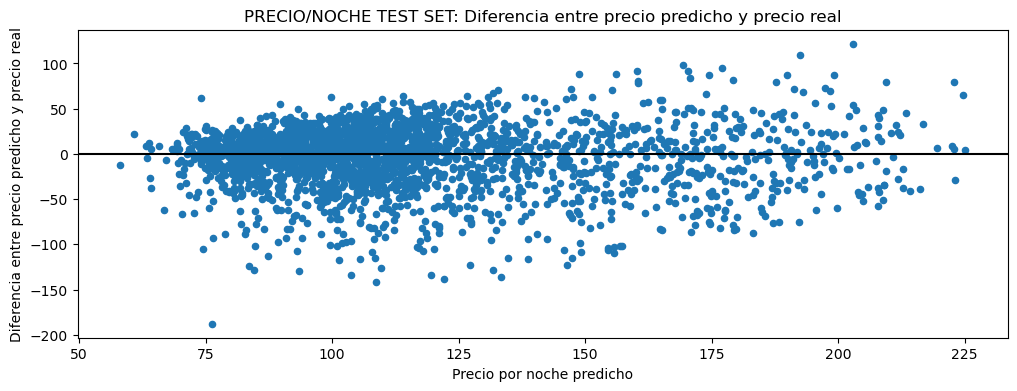

In [49]:
_,ax = plt.subplots(figsize=(12,4))
test_predict_analysis.plot.scatter(x="y_pred",y="y_pred_diff",ax=ax)
plt.axhline(0,c="k")
ax.set_title('PRECIO/NOCHE TEST SET: Diferencia entre precio predicho y precio real')
ax.set_xlabel("Precio por noche predicho")
ax.set_ylabel("Diferencia entre precio predicho y precio real")

### Exportamos el modelo definitivo entrenado

Lo primero que hacemos antes de exportar el modelo definitivo para poder hacer predicciones con otros DS es entrenar el modelo seleccionado con todos los datos disponibles de AirBnB y optimizar los hiperparámetros con el nuevo DS de entrenamiento.

In [75]:
dfm = pd.read_csv('../data/df_entrenamiento.csv')

In [76]:
target = "price"
y,X =dfm[target], dfm.drop(target,axis="columns")

In [77]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  12630 non-null  object 
 1   bathrooms                     12630 non-null  int64  
 2   bedrooms                      12630 non-null  int64  
 3   calefaccion                   12630 non-null  int64  
 4   piscina                       12630 non-null  int64  
 5   garaje                        12630 non-null  int64  
 6   aire_acondicionado            12630 non-null  int64  
 7   ascensor                      12630 non-null  int64  
 8   movilidad_reducida            12630 non-null  int64  
 9   terraza                       12630 non-null  int64  
 10  balcon                        12630 non-null  int64  
 11  distance_to_center            12630 non-null  float64
 12  distance_to_retiro            12630 non-null  float64
 13  d

Para poder utilizar el modelo con el DS de Idealista, lo primero que hay que hacer es cambiar tanto los nombres de las columnas como el orden de estas para que el modelo sea entrenado en las mimas condiciones en que después será utilizado para futuras predicciones.

In [78]:
X.rename(columns={'DISTANCE_TO_METRO':'distance_to_metro',
    'DISTANCE_TO_CERCANIAS':'distance_to_cercanias',
    'DISTANCE_TO_EMT':'distance_to_emt',
    'DISTANCE_TO_INTERURBANOS':'distance_to_interurbanos',
    'DISTANCE_TO_MLO':'distance_to_mlo',
    'neighbourhood_group_cleansed':"distrito"}, inplace=True)

In [79]:
#Ponemos en orden las columnas y renombramos para tener una consistencia para poder despues utilizar el modelo
order_columns = ['bedrooms', 'bathrooms','ascensor', 'piscina', 'garaje',
       'terraza', 'balcon', 'distance_to_center', 'aire_acondicionado',
       'movilidad_reducida', 'calefaccion', 'distance_to_metro',
       'distance_to_cercanias', 'distance_to_emt', 'distance_to_interurbanos',
       'distance_to_mlo','distance_to_retiro','distance_to_atocha','distance_to_chamartin','renta_bin','distrito']

In [80]:
X = X[order_columns]

In [81]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bedrooms                  12630 non-null  int64  
 1   bathrooms                 12630 non-null  int64  
 2   ascensor                  12630 non-null  int64  
 3   piscina                   12630 non-null  int64  
 4   garaje                    12630 non-null  int64  
 5   terraza                   12630 non-null  int64  
 6   balcon                    12630 non-null  int64  
 7   distance_to_center        12630 non-null  float64
 8   aire_acondicionado        12630 non-null  int64  
 9   movilidad_reducida        12630 non-null  int64  
 10  calefaccion               12630 non-null  int64  
 11  distance_to_metro         12630 non-null  float64
 12  distance_to_cercanias     12630 non-null  float64
 13  distance_to_emt           12630 non-null  float64
 14  distan

Ahora procedemos al procesado de los datos y la entrenamiento del modelo seleccionado y optimización de sus hiperparámetros con el 100% de los datos del DS de AirBnB.

In [82]:
numerical_features = X.select_dtypes(exclude='object').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
], remainder='passthrough')

In [83]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='linear'))
])

In [84]:
param_grid = {
    'regressor__C': [0.1, 1.0, 10.0],
    'regressor__epsilon': [0.1, 0.2, 0.3]
}

In [85]:
grid_search = GridSearchCV(pipe, param_grid, verbose=1)
grid_search.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['bedrooms',
                                                                          'bathrooms',
                                                                          'ascensor',
                                                                          'piscina',
                                                                          'garaje',
                                                                          'terraza',
                                                                          'balcon',
                                                                          'distance_to_center',
                                                                          'aire_acondicionado',
                                                                          'movilidad_reducida',
                                                                          'calefaccion',
                                                                          'distance_to_metro',
                                                                          'distance_to_cercanias',
                                                                          'distance_to_emt',
                                                                          'distance_to_interurbanos',
                                                                          'distance_to_mlo',
                                                                          'distance_to_retiro',
                                                                          'distance_to_atocha',
                                                                          'distance_to_chamartin']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['renta_bin',
                                                                          'distrito'])])),
                                       ('regressor', SVR(kernel='linear'))]),
             param_grid={'regressor__C': [0.1, 1.0, 10.0],
                         'regressor__epsilon': [0.1, 0.2, 0.3]},
             verbose=1)

In [86]:
best_model = grid_search.best_estimator_

In [87]:
y_pred = best_model.predict(X)

Comprobamos la precisión obtenida sobre el conjunto de entrenamiento.

In [88]:
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4038627715564739 mse: 1358.2667117828669 rmse: 36.85467014888163 mape: 0.2390826222145829


In [89]:
predict_analysis =pd.DataFrame({"y":y,"y_pred":y_pred})

Text(0, 0.5, 'Diferencia entre precio predicho y precio real')

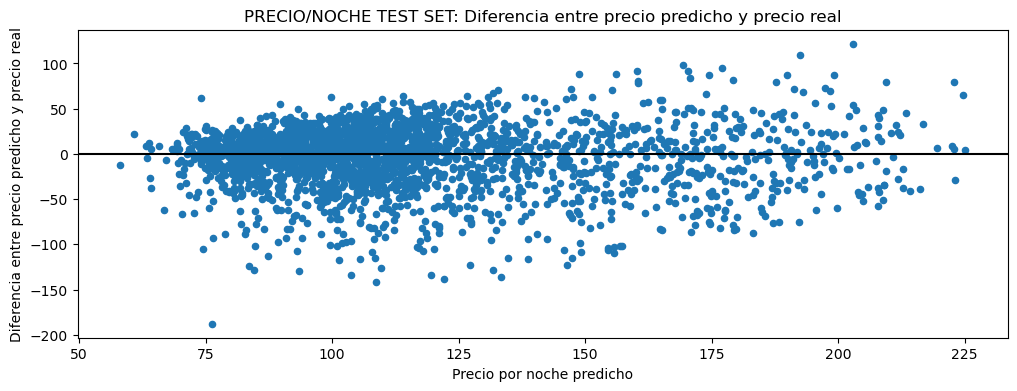

In [90]:
test_predict_analysis["y_pred_diff"]=test_predict_analysis["y_pred"]-test_predict_analysis["y"]

_,ax = plt.subplots(figsize=(12,4))
test_predict_analysis.plot.scatter(x="y_pred",y="y_pred_diff",ax=ax)
plt.axhline(0,c="k")
ax.set_title('PRECIO/NOCHE TEST SET: Diferencia entre precio predicho y precio real')
ax.set_xlabel("Precio por noche predicho")
ax.set_ylabel("Diferencia entre precio predicho y precio real")

In [91]:
# 🔍 Obtenemos los nombres de columnas transformadas:
# Para numéricas, los nombres se mantienen
num_names = numerical_features

# Para categóricas, necesitamos obtenerlos desde el OneHotEncoder
cat_names = best_model.named_steps["preprocessor"].named_transformers_['cat'].get_feature_names_out(categorical_features)

# # Combinamos ambos
all_feature_names = list(num_names) + list(cat_names)

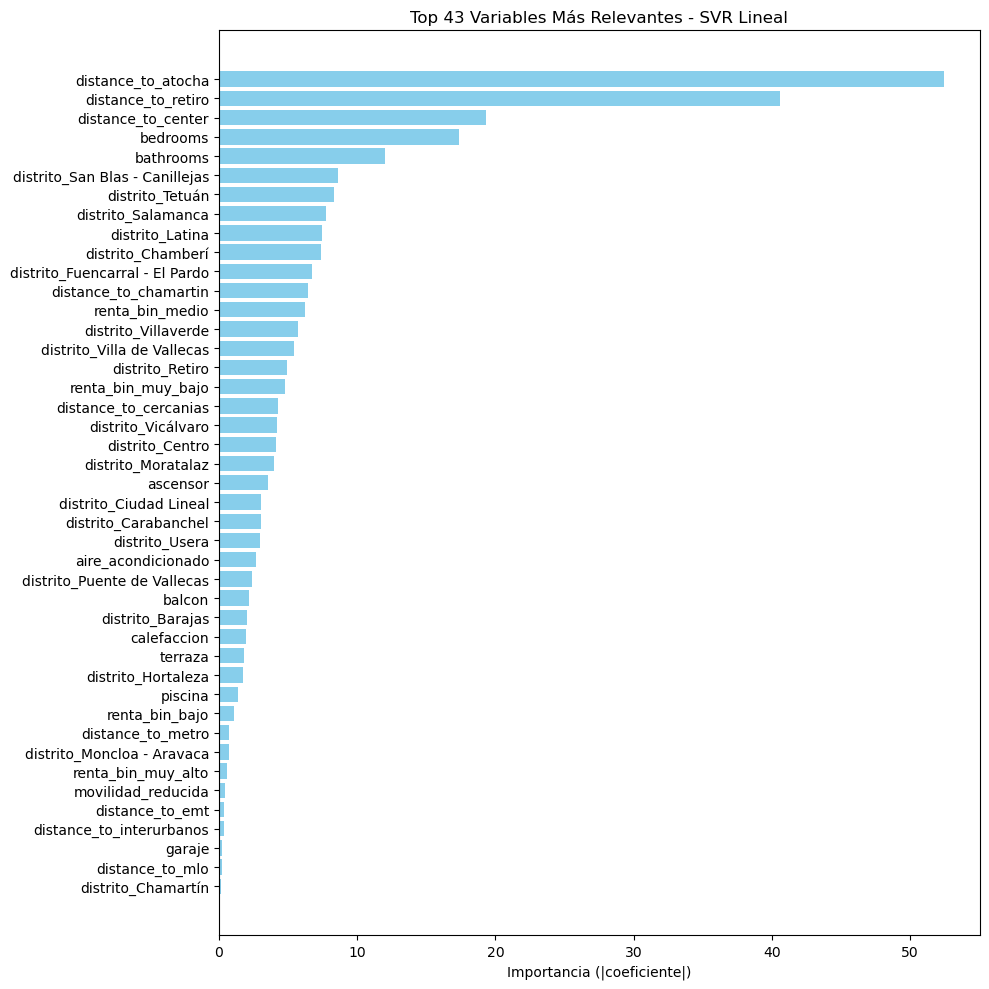

In [95]:
# Extraer los coeficientes absolutos
coeficientes = np.abs(best_model.named_steps['regressor'].coef_[0])

# Asociar coeficientes con nombres de variables
importancias_df = pd.DataFrame({
    'Variable': all_feature_names,
    'Importancia': coeficientes
}).sort_values(by='Importancia', ascending=False)

# Opcional: filtrar top N variables más importantes
top_n = 43
importancias_top = importancias_df.head(top_n)

# Graficar
plt.figure(figsize=(10, 10))
plt.barh(importancias_top['Variable'], importancias_top['Importancia'], color='skyblue')
plt.gca().invert_yaxis()  # Las más importantes arriba
plt.xlabel('Importancia (|coeficiente|)')
plt.title(f'Top {top_n} Variables Más Relevantes - SVR Lineal')
plt.tight_layout()
plt.show()

Y, finalmente, exportamos el modelo entrenado en un archivo llamado "_trainded_model.skops_".

In [96]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedrooms', 'bathrooms',
                                                   'ascensor', 'piscina',
                                                   'garaje', 'terraza',
                                                   'balcon',
                                                   'distance_to_center',
                                                   'aire_acondicionado',
                                                   'movilidad_reducida',
                                                   'calefaccion',
                                                   'distance_to_metro',
                                                   'distance_to_cercanias',
                                                   'distance_to_emt',
                                                   'distance_to_interurbanos',
                                                   'distance_to_mlo',
                                                   'distance_to_retiro',
                                                   'distance_to_atocha',
                                                   'distance_to_chamartin']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['renta_bin', 'distrito'])])),
                ('regressor', SVR(C=10.0, epsilon=0.2, kernel='linear'))])

In [97]:
dump(best_model, '../../model/model_tfm.skops')